In [1]:
import pandas as pd 
import math, random
all_data  = pd.read_csv("sensor_data_600.txt", delimiter=" ", header=None, names = ("date","time","ir","z"))#lidarのセンサ値は「z」に
data = all_data.sample(3000).sort_values(by="z").reset_index()  #1000個だけサンプリングしてインデックスを振り直す
data = pd.DataFrame(data["z"])

In [2]:
##負担率の初期化## 

K = 3 #クラスタ数
n = int(math.ceil(len(data)/K)) #クラスタあたりのセンサ値の数
for k in range(K):
    data[k] = [1.0 if k == int(i/n) else 0.0 for i,d in data.iterrows()] #データをK個に分けて、一つのr_{i,k}を1に。他を0に。

In [3]:
def update_parameters(ds, k, mu_avg=600, zeta=1, alpha=1, beta=1, tau=1): 
    R = sum([d[k] for _, d in ds.iterrows()])
    S = sum([d[k]*d["z"] for _, d in ds.iterrows()])
    T = sum([d[k]*(d["z"]**2) for _, d in ds.iterrows()])
    
    hat = {}

    hat["tau"] = R + tau
    hat["zeta"] = R + zeta
    hat["mu_avg"] = (S + zeta*mu_avg)/hat["zeta"]
    hat["alpha"] = R/2 + alpha
    hat["beta"] = (T + zeta*(mu_avg**2) - hat["zeta"]*(hat["mu_avg"]**2))/2 + beta
    
    hat["z_std"] = math.sqrt(hat["beta"]/hat["alpha"])
    
    return pd.DataFrame(hat, index=[k])

In [4]:
from scipy.stats import norm, dirichlet
import matplotlib.pyplot as plt
import numpy as np

def draw(ps):
    pi = dirichlet([ps["tau"][k] for k in range(K)]).rvs()[0]
    pdfs = [ norm(loc=ps["mu_avg"][k], scale=ps["z_std"][k]) for k in range(K) ]

    xs = np.arange(600,650,0.5)

    ##p(z)の描画##
    ys = [ sum([pdfs[k].pdf(x)*pi[k] for k in range(K)])*len(data) for x in xs] #pdfを足してデータ数をかける
    plt.plot(xs, ys, color="red")

    ##各ガウス分布の描画##
    for k in range(K):
        ys = [pdfs[k].pdf(x)*pi[k]*len(data) for x in xs]
        plt.plot(xs, ys, color="blue")

    ##元のデータのヒストグラムの描画##
    data["z"].hist(bins = max(data["z"]) - min(data["z"]), align='left', alpha=0.4, color="gray")
    plt.show()

In [5]:
from scipy.special import digamma 

def responsibility(z, K, ps):
    tau_sum = sum([ps["tau"][k] for k in range(K)])
    r = {}
    for k in range(K):
        log_rho = (digamma(ps["alpha"][k]) - math.log(ps["beta"][k]))/2 \
                            - (1/ps["zeta"][k] + ((ps["mu_avg"][k] - z)**2)*ps["alpha"][k]/ps["beta"][k])/2 \
                            + digamma(ps["tau"][k]) - digamma(tau_sum)
                
        r[k] = math.exp(log_rho)
       
    w = sum([ r[k] for k in range(K) ]) #正規化
    for k in range(K): r[k] /= w
    
    return r

In [6]:
def one_step(ds): ###variationalinference2onestep
    ##パラメータの更新##
    params = pd.concat([update_parameters(ds, k) for k in range(K)]) 

    ##負担率の更新##
    rs = [responsibility(d["z"], K, params) for _, d in ds.iterrows() ]
    for k in range(K):
        ds[k] = [rs[i][k] for i,_ in data.iterrows()]
        
    return ds, params

In [7]:
params_history = {} ###variationalinference2iter
for t in range(1, 10000):
    data, params = one_step(data)
    if t%10 ==0:              #10回ごとにパラメータを記録
        params_history[t] = params
        display(params)
        
        if len(params_history) < 2:
            continue
           
        if all([ abs(params_history[t-10]["tau"][k] - params_history[t]["tau"][k]) < 10e-5 for k in range(K)]):
            break

,tau,zeta,mu_avg,alpha,beta,z_std
0,993.604301,993.604301,620.705580,497.302150,5340.619442,3.277069
1,915.874983,915.874983,627.495038,458.437492,7488.235206,4.041566
2,1093.520716,1093.520716,632.150127,547.260358,6746.088652,3.510985


,tau,zeta,mu_avg,alpha,beta,z_std
0,957.563619,957.563619,620.867027,479.281809,5374.332028,3.348627
1,876.661535,876.661535,627.459489,438.830768,10506.333783,4.893021
2,1168.774846,1168.774846,631.535429,584.887423,7869.782899,3.668134


,tau,zeta,mu_avg,alpha,beta,z_std
0,933.936570,933.936570,620.926433,467.468285,5162.210649,3.323088
1,817.205510,817.205510,627.148849,409.102755,11267.621424,5.248074
2,1251.857921,1251.857921,631.298959,626.428960,8640.163555,3.713856


,tau,zeta,mu_avg,alpha,beta,z_std
0,919.694025,919.694025,620.963164,460.347012,4982.497568,3.289886
1,752.673377,752.673377,626.724630,376.836688,11029.993265,5.410172
2,1330.632598,1330.632598,631.201239,665.816299,9329.986401,3.743375


,tau,zeta,mu_avg,alpha,beta,z_std
0,913.877212,913.877212,620.997787,457.438606,4870.979705,3.263185
1,689.866011,689.866011,626.311166,345.433005,10448.546260,5.499789
2,1399.256778,1399.256778,631.138975,700.128389,9941.965026,3.768316


,tau,zeta,mu_avg,alpha,beta,z_std
0,915.722335,915.722335,621.027953,458.361168,4826.469529,3.244971
1,630.091955,630.091955,625.958335,315.545978,9725.493269,5.551681
2,1457.185709,1457.185709,631.087387,729.092855,10476.511257,3.790678


,tau,zeta,mu_avg,alpha,beta,z_std
0,923.523510,923.523510,621.053523,462.261755,4836.267089,3.234530
1,573.625584,573.625584,625.670865,287.312792,8967.294745,5.586673
2,1505.850906,1505.850906,631.040996,753.425453,10939.083558,3.810398


,tau,zeta,mu_avg,alpha,beta,z_std
0,935.393354,935.393354,621.075938,468.196677,4884.110622,3.229822
1,520.450454,520.450454,625.435737,260.725227,8229.624797,5.618217
2,1547.156192,1547.156192,630.998594,774.078096,11339.877482,3.827470


,tau,zeta,mu_avg,alpha,beta,z_std
0,949.827993,949.827993,621.096106,475.413997,4956.698104,3.228942
1,470.394411,470.394411,625.237931,235.697205,7532.417238,5.653143
2,1582.777596,1582.777596,630.959843,791.888798,11690.276309,3.842203


,tau,zeta,mu_avg,alpha,beta,z_std
0,965.775635,965.775635,621.114344,483.387817,5044.881829,3.230559
1,423.230872,423.230872,625.065062,212.115436,6878.204805,5.694445
2,1613.993493,1613.993493,630.924519,807.496747,12000.191926,3.854994


,tau,zeta,mu_avg,alpha,beta,z_std
0,982.534404,982.534404,621.130727,491.767202,5142.746829,3.233835
1,378.736772,378.736772,624.907524,189.868386,6263.210698,5.743441
2,1641.728825,1641.728825,630.892397,821.364412,12277.335022,3.866198


,tau,zeta,mu_avg,alpha,beta,z_std
0,999.644176,999.644176,621.145278,500.322088,5246.562259,3.238266
1,336.714974,336.714974,624.757680,168.857487,5682.135612,5.800903
2,1666.640850,1666.640850,630.863257,833.820425,12527.414932,3.876095


,tau,zeta,mu_avg,alpha,beta,z_std
0,1016.807087,1016.807087,621.158028,508.903543,5354.037341,3.243568
1,297.000025,297.000025,624.609072,149.000013,5129.893213,5.867607
2,1689.192888,1689.192888,630.836900,845.096444,12754.560893,3.884898


,tau,zeta,mu_avg,alpha,beta,z_std
0,1033.833904,1033.833904,621.169022,517.416952,5463.850948,3.249594
1,259.458084,259.458084,624.455756,130.229042,4602.125557,5.944637
2,1709.708013,1709.708013,630.813158,855.354006,12961.704121,3.892764


,tau,zeta,mu_avg,alpha,beta,z_std
0,1050.608323,1050.608323,621.178314,525.804161,5575.367523,3.256302
1,223.985643,223.985643,624.291686,112.492822,4095.266884,6.033630
2,1728.406034,1728.406034,630.791895,864.703017,13150.863780,3.899812


,tau,zeta,mu_avg,alpha,beta,z_std
0,1067.062934,1067.062934,621.185958,534.031467,5688.476261,3.263732
1,190.508887,190.508887,624.109979,95.754444,3606.453071,6.137064
2,1745.428179,1745.428179,630.773013,873.214089,13323.342188,3.906126


,tau,zeta,mu_avg,alpha,beta,z_std
0,1083.162808,1083.162808,621.192002,542.081404,5803.518004,3.272001
1,158.984561,158.984561,623.901858,79.992280,3133.389677,6.258686
2,1760.852631,1760.852631,630.756456,880.926316,13479.845395,3.911764


,tau,zeta,mu_avg,alpha,beta,z_std
0,1098.894259,1098.894259,621.196488,549.94713,5921.290500,3.281313
1,129.403160,129.403160,623.654826,65.20158,2674.219575,6.404268
2,1774.702580,1774.702580,630.742217,887.85129,13620.539103,3.916761


,tau,zeta,mu_avg,alpha,beta,z_std
0,1114.257264,1114.257264,621.199456,557.628632,6043.145873,3.291994
1,101.795795,101.795795,623.349089,51.397897,2227.400273,6.583039
2,1786.946941,1786.946941,630.730354,893.973471,13745.039043,3.921125


,tau,zeta,mu_avg,alpha,beta,z_std
0,1129.260572,1129.260572,621.200952,565.130286,6171.237081,3.304546
1,76.247745,76.247745,622.949453,38.623872,1791.581277,6.810678
2,1797.491683,1797.491683,630.721008,899.245842,13852.313977,3.924840


,tau,zeta,mu_avg,alpha,beta,z_std
0,1143.918210,1143.918210,621.201047,572.459105,6309.055474,3.319785
1,52.926522,52.926522,622.383573,26.963261,1365.441949,7.116237
2,1806.155268,1806.155268,630.714442,903.577634,13940.438594,3.927855


,tau,zeta,mu_avg,alpha,beta,z_std
0,1158.242284,1158.242284,621.199897,579.621142,6462.628631,3.339124
1,32.149098,32.149098,621.466658,16.574549,947.339982,7.560179
2,1812.608619,1812.608619,630.711125,906.804309,14006.010377,3.930071


,tau,zeta,mu_avg,alpha,beta,z_std
0,1172.192084,1172.192084,621.197982,586.596042,6643.145820,3.365250
1,14.597279,14.597279,619.496878,7.798639,533.831948,8.273568
2,1816.210637,1816.210637,630.711907,908.605319,14042.535689,3.931290


,tau,zeta,mu_avg,alpha,beta,z_std
0,1185.068412,1185.068412,621.198119,593.034206,6862.827704,3.401823
1,2.535529,2.535529,609.764710,1.767764,104.224126,7.678422
2,1815.396060,1815.396060,630.718377,908.198030,14032.940201,3.930828


,tau,zeta,mu_avg,alpha,beta,z_std
0,1192.298763,1192.298763,621.214956,596.649382,6997.890222,3.424711
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1809.701237,1809.701237,630.732937,905.350618,13949.005427,3.925213


,tau,zeta,mu_avg,alpha,beta,z_std
0,1196.383195,1196.383195,621.228535,598.691597,7046.781732,3.430788
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1805.616805,1805.616805,630.745470,903.308403,13869.485081,3.918430


,tau,zeta,mu_avg,alpha,beta,z_std
0,1198.966688,1198.966688,621.237084,599.983344,7077.629823,3.434585
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1803.033312,1803.033312,630.753421,902.016656,13819.089241,3.914105


,tau,zeta,mu_avg,alpha,beta,z_std
0,1200.599969,1200.599969,621.242497,600.799985,7097.218050,3.436997
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1801.400031,1801.400031,630.758442,901.200015,13787.345159,3.911377


,tau,zeta,mu_avg,alpha,beta,z_std
0,1201.632505,1201.632505,621.245922,601.316252,7109.636890,3.438525
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1800.367495,1800.367495,630.761614,900.683748,13767.324592,3.909657


,tau,zeta,mu_avg,alpha,beta,z_std
0,1202.285252,1202.285252,621.248089,601.642626,7117.502008,3.439494
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1799.714748,1799.714748,630.763618,900.357374,13754.687022,3.908570


,tau,zeta,mu_avg,alpha,beta,z_std
0,1202.697905,1202.697905,621.249459,601.848953,7122.479793,3.440106
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1799.302095,1799.302095,630.764884,900.151047,13746.705473,3.907884


,tau,zeta,mu_avg,alpha,beta,z_std
0,1202.958775,1202.958775,621.250325,601.979387,7125.629003,3.440494
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1799.041225,1799.041225,630.765685,900.020613,13741.662698,3.907450


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.123691,1203.123691,621.250873,602.061846,7127.620742,3.440739
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.876309,1798.876309,630.766191,899.938154,13738.475994,3.907176


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.227948,1203.227948,621.251219,602.113974,7128.880245,3.440894
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.772052,1798.772052,630.766510,899.886026,13736.461927,3.907003


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.293857,1203.293857,621.251438,602.146928,7129.676596,3.440992
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.706143,1798.706143,630.766713,899.853072,13735.188847,3.906893


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.335522,1203.335522,621.251577,602.167761,7130.180101,3.441054
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.664478,1798.664478,630.766840,899.832239,13734.384147,3.906824


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.361862,1203.361862,621.251664,602.180931,7130.498412,3.441093
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.638138,1798.638138,630.766921,899.819069,13733.875447,3.906780


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.378515,1203.378515,621.251719,602.189257,7130.699699,3.441118
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.621485,1798.621485,630.766972,899.810743,13733.553857,3.906752


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.389042,1203.389042,621.251754,602.194521,7130.826906,3.441134
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.610958,1798.610958,630.767005,899.805479,13733.350568,3.906735


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.395697,1203.395697,621.251777,602.197849,7130.907352,3.441144
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.604303,1798.604303,630.767025,899.802151,13733.222054,3.906724


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.399904,1203.399904,621.251791,602.199952,7130.958194,3.441150
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.600096,1798.600096,630.767038,899.800048,13733.140807,3.906717


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.402564,1203.402564,621.251799,602.201282,7130.990315,3.441154
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.597436,1798.597436,630.767046,899.798718,13733.089453,3.906712


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.404245,1203.404245,621.251805,602.202123,7131.010654,3.441156
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.595755,1798.595755,630.767051,899.797877,13733.056949,3.906710


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.405308,1203.405308,621.251809,602.202654,7131.023532,3.441158
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.594692,1798.594692,630.767054,899.797346,13733.036453,3.906708


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.40598,1203.40598,621.251811,602.20299,7131.031641,3.441159
1,1.00000,1.00000,600.000000,1.00000,1.000000,1.000000
2,1798.59402,1798.59402,630.767057,899.79701,13733.023480,3.906707


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.406404,1203.406404,621.251812,602.203202,7131.036773,3.441160
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.593596,1798.593596,630.767058,899.796798,13733.015311,3.906706


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.406673,1203.406673,621.251813,602.203336,7131.039989,3.441160
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.593327,1798.593327,630.767059,899.796664,13733.010088,3.906706


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.406842,1203.406842,621.251814,602.203421,7131.042052,3.441160
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.593158,1798.593158,630.767059,899.796579,13733.006843,3.906705


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.406949,1203.406949,621.251814,602.203475,7131.043343,3.441160
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.593051,1798.593051,630.767059,899.796525,13733.004750,3.906705


,tau,zeta,mu_avg,alpha,beta,z_std
0,1203.407018,1203.407018,621.251814,602.203509,7131.044198,3.441160
1,1.000000,1.000000,600.000000,1.000000,1.000000,1.000000
2,1798.592982,1798.592982,630.767060,899.796491,13733.003435,3.906705


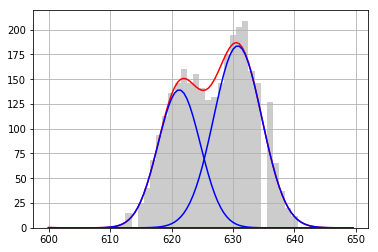

In [8]:
draw(params) ###variationalinference2draw

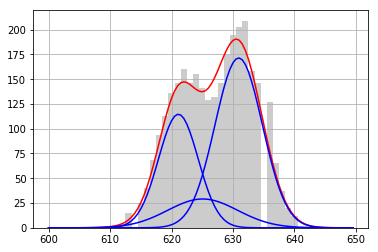

In [9]:
draw(params_history[100])

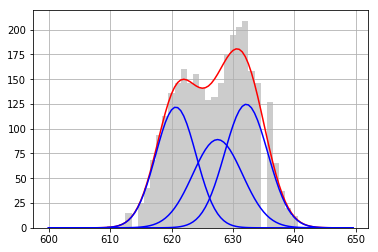

In [10]:
draw(params_history[10])

In [11]:
params_history

{10:            tau         zeta      mu_avg       alpha         beta     z_std
 0   993.604301   993.604301  620.705580  497.302150  5340.619442  3.277069
 1   915.874983   915.874983  627.495038  458.437492  7488.235206  4.041566
 2  1093.520716  1093.520716  632.150127  547.260358  6746.088652  3.510985,
 20:            tau         zeta      mu_avg       alpha          beta     z_std
 0   957.563619   957.563619  620.867027  479.281809   5374.332028  3.348627
 1   876.661535   876.661535  627.459489  438.830768  10506.333783  4.893021
 2  1168.774846  1168.774846  631.535429  584.887423   7869.782899  3.668134,
 30:            tau         zeta      mu_avg       alpha          beta     z_std
 0   933.936570   933.936570  620.926433  467.468285   5162.210649  3.323088
 1   817.205510   817.205510  627.148849  409.102755  11267.621424  5.248074
 2  1251.857921  1251.857921  631.298959  626.428960   8640.163555  3.713856,
 40:            tau         zeta      mu_avg       alpha         